<a href="https://colab.research.google.com/github/epodkwan/growthfunction/blob/main/bsplineemulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import random
import statistics
from typing import Sequence
import jax
import optax
import numpy as np
import jax.numpy as jnp
from jax import jit,vmap
from flax import linen as nn
from flax.training import train_state,checkpoints
import matplotlib
import matplotlib.pyplot as plt

In [3]:
class SimpleMLP(nn.Module):
    features:Sequence[int]
    nodes:int

    @nn.compact
    def __call__(self,inputs):
        x=inputs
        for i,feat in enumerate(self.features):
            x=nn.Dense(feat)(x)
            x=jnp.sin(x)
        t=nn.Dense(nodes-1)(x)
        c=nn.Dense(nodes+1)(x)
        t=jnp.concatenate([jnp.zeros((t.shape[0],4)),jnp.cumsum(jax.nn.softmax(t),axis=1),jnp.ones((t.shape[0],3))],axis=1)
        c=jnp.concatenate([jnp.zeros((c.shape[0],1)),c],axis=1)
        return t,c

In [4]:
def npy_loader(path):
    return jnp.load(path)

In [5]:
@jit
def _deBoorVectorized(x,t,c):
    p=3
    k=jnp.digitize(x,t)-1
    d=[c[j+k-p] for j in range(0,p+1)]
    for r in range(1,p+1):
        for j in range(p,r-1,-1):
            alpha=(x-t[j+k-p])/(t[j+1+k-r]-t[j+k-p])
            d[j]=(1.0-alpha)*d[j-1]+alpha*d[j]
    return d[p]

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
layer_sizes=[64,64]
nodes=16
learning_rate=1e-3
model=SimpleMLP(features=layer_sizes,nodes=nodes)
temp=jnp.array([[1,1]])
params=model.init(jax.random.PRNGKey(0),temp)
tx=optax.adam(learning_rate=learning_rate)
opt_state=tx.init(params)
deBoor=vmap(_deBoorVectorized,in_axes=(None,0,0))
state=train_state.TrainState.create(apply_fn=model.apply,params=params,tx=tx)
restored_state=checkpoints.restore_checkpoint(ckpt_dir="/content/drive/My Drive/Colab Notebooks/checkpoint_0",target=state)

In [8]:
@jit
def eval_func(params,x,a):
    t,c=restored_state.apply_fn(params,x)
    preds=deBoor(jnp.clip(a,0,0.999),t,c).reshape(-1)
    return preds

<Figure size 432x288 with 0 Axes>

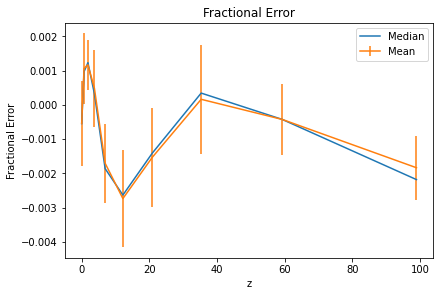

In [9]:
cosmo=npy_loader("/content/drive/My Drive/Colab Notebooks/cosmo.npy")
cosmo_num=random.randrange(1000)
parameters=np.array([[cosmo[cosmo_num,0],cosmo[cosmo_num,2]]])
input_result=npy_loader("/content/drive/My Drive/Colab Notebooks/combined.npy")
z=npy_loader("/content/drive/My Drive/Colab Notebooks/999.npy")[0,:]
a=1/(z+1)
d_data=input_result[cosmo_num,:]
d_test=jnp.exp(eval_func(restored_state.params,parameters,a))
discrepancy=d_test/d_data
fig,(ax1,ax2)=plt.subplots(2,1,constrained_layout=True)
ax1.plot(z,d_data,label="Reference")
ax1.plot(z,d_test,label="Fitting")
ax1.set_yscale('log')
ax1.set_ylabel("D")
ax1.legend()
ax1.set_title("Omega_m="+str(jnp.round(parameters[0,0],3))+", H0="+str(jnp.round(parameters[0,1],3)))
ax2.plot(z,discrepancy,label="Discrepancy")
ax2.set_xlabel("z")
ax2.set_ylabel("Predict/Data")
ax2.ticklabel_format(useOffset=False)
ax2.legend()
plt.savefig("/content/drive/My Drive/Colab Notebooks/cosmo"+str(cosmo_num)+".png")
z_plot=[]
med=[]
mean_error=[]
std=[]
for i in range(10):
    plt.clf()
    temp=[]
    for j in range(1000):
        cosmo_num=j
        d_data=input_result[cosmo_num,:]
        parameters[0,0]=cosmo[cosmo_num,0]
        parameters[0,1]=cosmo[cosmo_num,2]
        d_test=jnp.exp(eval_func(restored_state.params,parameters,a))
        temp.append((d_test[i*28]/d_data[i*28]-1).item())
        plt.scatter(cosmo[cosmo_num,0].item(),cosmo[cosmo_num,2].item(),c=temp[-1],cmap='coolwarm',vmin=-0.01,vmax=0.01)
    plt.colorbar()
    plt.xlabel("Omega_m")
    plt.ylabel("H0")
    plt.title("Fractional Error of Cosmos (z="+str(jnp.round(z[i*28].item(),3))+")")
    plt.savefig("/content/drive/My Drive/Colab Notebooks/error"+str(i)+".png")
    z_plot.append(z[i*28].item())
    med.append(statistics.median(temp))
    mean_error.append(statistics.mean(temp))
    std.append(statistics.stdev(temp))
plt.clf()
fig,ax=plt.subplots(constrained_layout=True)
ax.plot(z_plot,med,label="Median")
ax.errorbar(z_plot,mean_error,std,label="Mean")
ax.set_xlabel("z")
ax.set_ylabel("Fractional Error")
ax.set_title("Fractional Error")
ax.legend()
plt.savefig("/content/drive/My Drive/Colab Notebooks/centralerror.png")
